In [91]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from IPython.display import display


Table of contents

Import and preprocessing

<h1>Bitte nicht so viele Datasets löschen!</h1>

In [145]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score

#NaN Werte nochmals herauswerte --> checken welchen Stellenwert Yearbuilt oder die anderen haben.

def process_year_built(dataframe):
    # Konvertieren in Datetime und nur das Jahr extrahieren
    dataframe['YearBuilt'] = pd.to_datetime(dataframe['YearBuilt'], errors='coerce').dt.year
    # Entfernen von Zeilen mit NaN in 'YearBuilt'
    dataframe = dataframe.dropna(subset=['Rooms','SquareMeter','Floor','YearBuilt','Price','longitude','latitude','incometax_canton','incometax_municipality','wealthtax_canton','wealthtax_municipality','population_density','public_transport_count','supermarket_count','foodandbeverage_count','Price_per_m2'])
    # Entfernen von Zeilen mit 0 in 'YearBuilt'
    #dataframe = dataframe[dataframe['YearBuilt'] != 0]
    return dataframe


df_location = pd.read_csv('filtered_property_location_clean.csv', delimiter=';')

#List of columns to drop
columns_to_drop = ['YearBuilt','Canton','ObjectType','Timestamp','LocationId', 'Availability','AdditionalCost','NetPrice', 'PropertyAdditionalFeaturesId','Vendor', 'street', 'zip','PropertyDescription','bfs_number','municipality','ListingId',]

# Bearbeiten der 'YearBuilt'-Spalte im ersten DataFrame
df = process_year_built(df_location)


#Drop the specified columns from df_encoded_corrected_final
df= df.drop(columns=columns_to_drop)

# Konvertiere 'EG' zu 0 in der relevanten Spalte (hier angenommen, dass 'Floor' die relevante Spalte ist)
if 'Floor' in df.columns:
    df['Floor'] = df['Floor'].replace('EG', 0)
    df['Floor'] = df['Floor'].astype(float)
    # Entfernen der Zeilen, in denen 'Floor' NaN ist
    df = df.dropna(subset=['Floor'])



# Überprüfe, ob die Spalte 'Canton' vorhanden ist
print(df.columns)

#Check whether there is any null values
df.info()

#Lets find out how many unique values are present in each column

for value in df:
    print('For {},{} unique values present'.format(value,df[value].nunique()))

df.to_clipboard()

Index(['Rooms', 'SquareMeter', 'Floor', 'Price', 'longitude', 'latitude',
       'incometax_canton', 'incometax_municipality', 'wealthtax_canton',
       'wealthtax_municipality', 'population_density',
       'public_transport_count', 'supermarket_count', 'foodandbeverage_count',
       'Price_per_m2'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 4152 entries, 0 to 8842
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Rooms                   4152 non-null   float64
 1   SquareMeter             4152 non-null   float64
 2   Floor                   4152 non-null   float64
 3   Price                   4152 non-null   float64
 4   longitude               4152 non-null   float64
 5   latitude                4152 non-null   float64
 6   incometax_canton        4152 non-null   float64
 7   incometax_municipality  4152 non-null   float64
 8   wealthtax_canton        4152 non-nul

<H1>Codierung mit neuer Variante bearbeiten!</h1>

In [ ]:
# One-Hot-Encoding auf die Feature-Spalte anwenden
df_features_encoded = pd.get_dummies(df_data_PropertyAdditionalFeatures['Feature'])

# Konvertiere die One-Hot-Encoding Spalten explizit zu int
df_features_encoded = df_features_encoded.astype(int)

# Original DataFrame ohne die Feature-Spalte und das Ergebnis des One-Hot-Encoding verknüpfen
df_encoded = pd.concat([df_data_PropertyAdditionalFeatures.drop('Feature', axis=1), df_features_encoded], axis=1)

# Ausgabe des neuen DataFrames, um die Encodierung zu überprüfen
print(df_encoded)

/Users/elras/anaconda3/envs/adsenv/lib/python3.11/site-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1000x600 with 0 Axes>

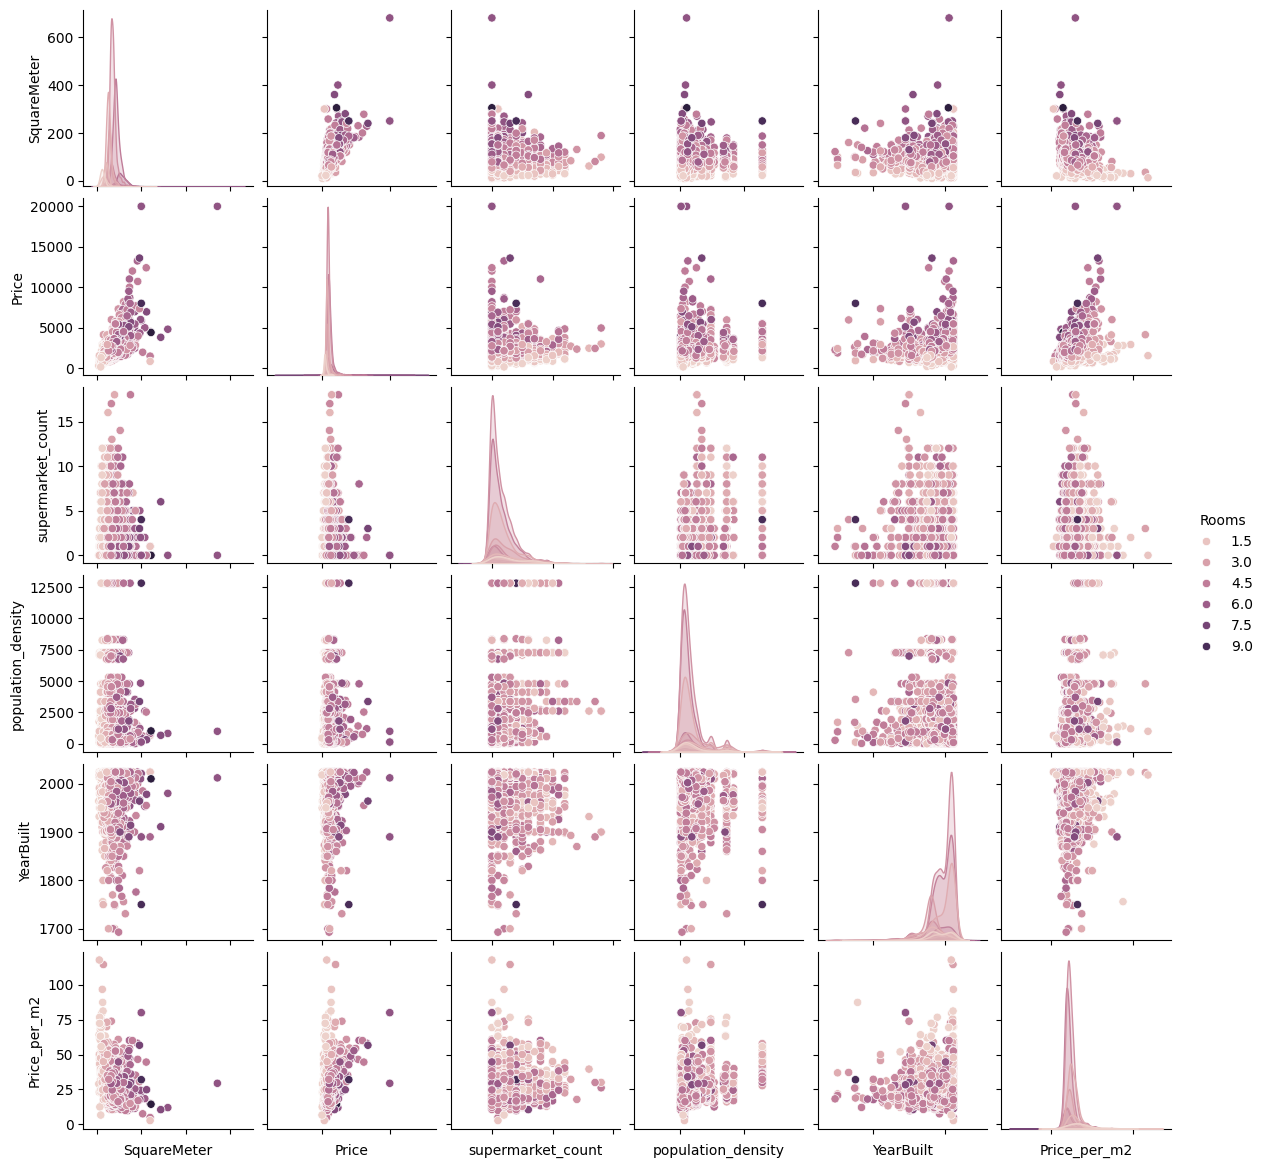

In [113]:
plt.figure(figsize=(10,6))
sns.plotting_context('notebook',font_scale=1.2)
g = sns.pairplot(df[['SquareMeter','Price','Rooms','supermarket_count','population_density','YearBuilt','Price_per_m2']]
                 ,hue='Rooms',size=2)
g.set(xticklabels=[])

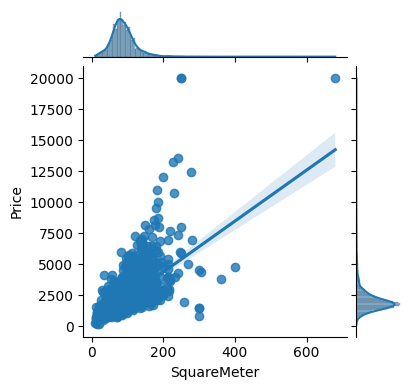

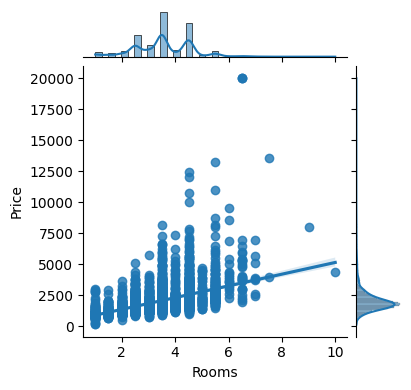

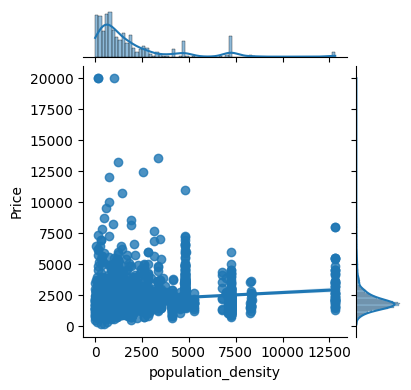

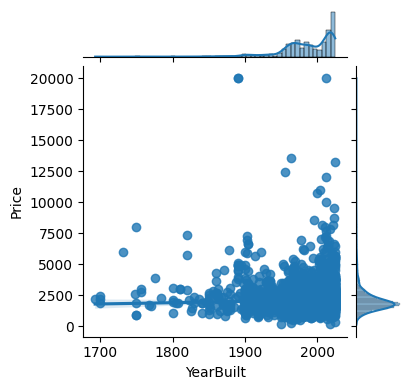

In [114]:
# Corrected code for jointplot with 'height' parameter
sns.jointplot(x='SquareMeter', y='Price', data=df, kind='reg', height=4)
sns.jointplot(x='Rooms', y='Price', data=df, kind='reg', height=4)
sns.jointplot(x='population_density', y='Price', data=df, kind='reg', height=4)
sns.jointplot(x='YearBuilt', y='Price', data=df, kind='reg', height=4)

# Show the plots
plt.show()

<Axes: >

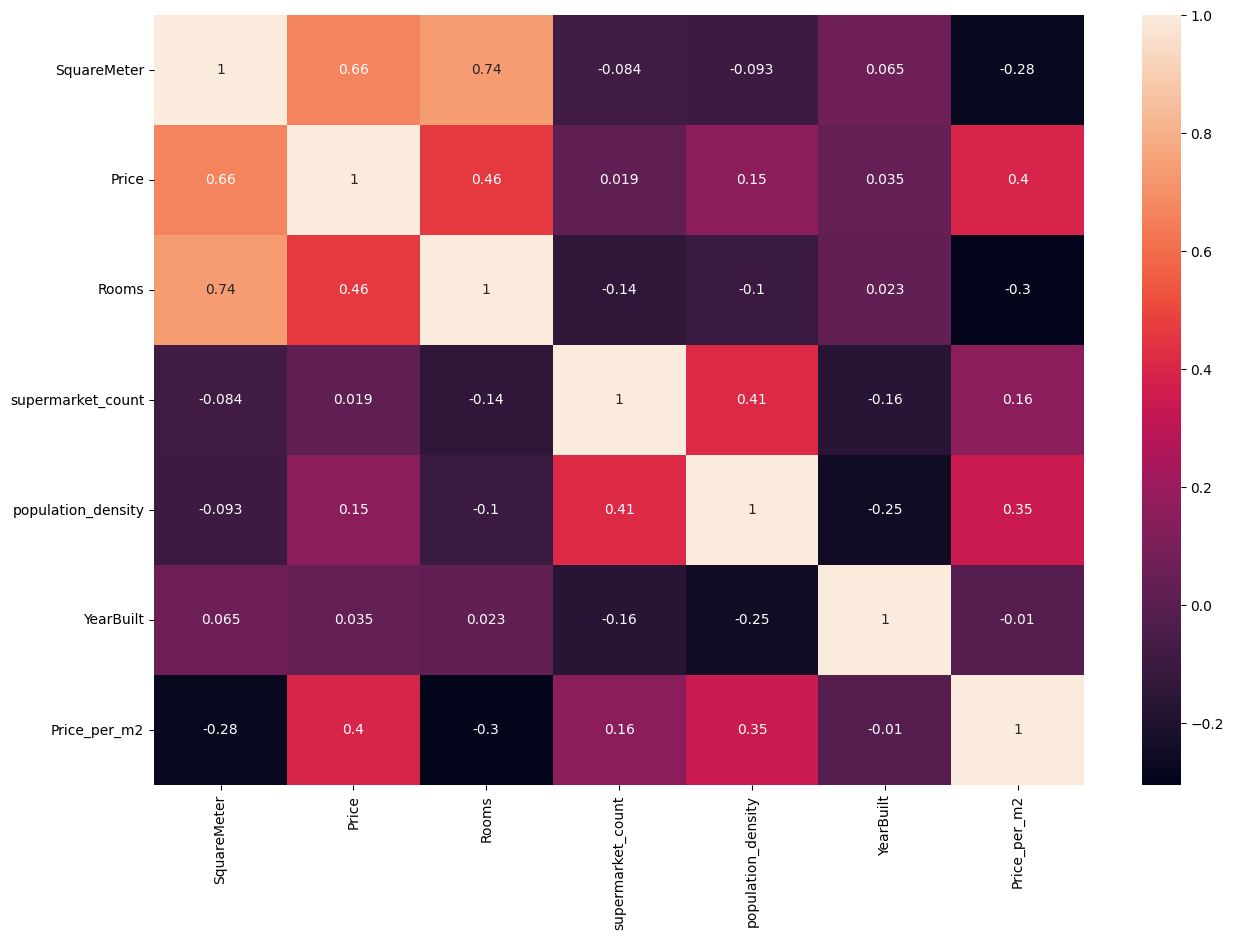

In [115]:
plt.figure(figsize=(15,10))
columns =['SquareMeter','Price','Rooms','supermarket_count','population_density','YearBuilt','Price_per_m2']
sns.heatmap(df[columns].corr(),annot=True)

<h1>Split data and train </h1>

<H1>XGBoost noch implementieren!</h1>

In [144]:
# X(Independent variables) and y(target variables) // Price ned Rooms was hesch da gmacht!
X = df.iloc[:,1:].values
y = df.iloc[:,0].values

print(X)
print(y)


#Splitting the data into train,test data 
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

df.to_clipboard()

[[9.30000000e+01 1.00000000e+00 1.92000000e+03 ... 0.00000000e+00
  0.00000000e+00 2.06451613e+01]
 [6.20000000e+01 2.00000000e+00 1.73000000e+03 ... 1.00000000e+00
  3.00000000e+00 2.79032258e+01]
 [7.60000000e+01 3.00000000e+00 1.43000000e+03 ... 0.00000000e+00
  1.00000000e+00 1.88157895e+01]
 ...
 [7.90000000e+01 2.00000000e+00 2.74500000e+03 ... 0.00000000e+00
  4.00000000e+00 3.47468354e+01]
 [6.60000000e+01 1.00000000e+00 2.13000000e+03 ... 2.00000000e+00
  1.10000000e+01 3.22727273e+01]
 [5.80000000e+01 4.00000000e+00 2.90000000e+03 ... 5.00000000e+00
  8.90000000e+01 5.00000000e+01]]
[2.5 2.5 3.5 ... 4.  4.  2.5]


In [126]:
# Multiple Linear Regression
mlr = LinearRegression()
mlr.fit(X_train, y_train)
mlr_score = mlr.score(X_test, y_test)
pred_mlr = mlr.predict(X_test)
expl_mlr = explained_variance_score(y_test, pred_mlr)

print(f"Model Score: {mlr_score}")
print(f"Explained Variance Score: {expl_mlr}")

Model Score: 0.5252452727256203
Explained Variance Score: 0.5259621964950818


In [128]:
from sklearn.tree import DecisionTreeRegressor


tr_regressor = DecisionTreeRegressor(random_state=0)
tr_regressor.fit(X_train,y_train)
tr_regressor.score(X_test,y_test)
pred_tr = tr_regressor.predict(X_test)
decision_score=tr_regressor.score(X_test,y_test)
expl_tr = explained_variance_score(pred_tr,y_test)

In [129]:
rf_regressor = RandomForestRegressor(n_estimators=28,random_state=0)
rf_regressor.fit(X_train,y_train)
rf_regressor.score(X_test,y_test)
rf_pred =rf_regressor.predict(X_test)
rf_score=rf_regressor.score(X_test,y_test)
expl_rf = explained_variance_score(rf_pred,y_test)


Modell bewerten

Schritt 7: Modell verwenden für Vorhersagen

In [139]:
print("Multiple Linear Regression Model Score is ",round(mlr.score(X_test,y_test)*100))
print("Decision tree  Regression Model Score is ",round(tr_regressor.score(X_test,y_test)*100))
print("Random Forest Regression Model Score is ",round(rf_regressor.score(X_test,y_test)*100))

#Let's have a tabular pandas data frame, for a clear comparison

models_score =pd.DataFrame({'Model':['Multiple Linear Regression','Decision Tree','Random forest Regression'],
                            'Score':[mlr_score,decision_score,rf_score],
                            'Explained Variance Score':[expl_mlr,expl_tr,expl_rf]
                           })
models_score.sort_values(by='Score',ascending=False)

Multiple Linear Regression Model Score is  53
Decision tree  Regression Model Score is  51
Random Forest Regression Model Score is  72


,Model,Score,Explained Variance Score
2,Random forest Regression,0.723873,0.627068
0,Multiple Linear Regression,0.525245,0.525962
1,Decision Tree,0.505818,0.472766
